In [100]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
import nbformat

from metaphone import doublemetaphone

In [101]:
print(nbformat.__version__)

5.10.4


## Loading Datasets

In [102]:
movies_df = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t',names=['Wikipedia_ID','Freebase_ID','Name','Release_date','Box_office_revenues','Runtime','Languages','Country','Genres'])
movies_df.head()

,Wikipedia_ID,Freebase_ID,Name,Release_date,Box_office_revenues,Runtime,Languages,Country,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [103]:
character_df = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t', names=['Wikipedia_ID','Freebase_ID','Release_date','Character_name','Actor_DOB',
                                                                                    'Sex','Height','Ethnicity','Actor_name','Actor_age','Freebase_character_map'
                                                                                    ,'?','??'])##

In [104]:
# Cleaning Languages, Country and Genres Columns

def str_dict_to_values(dict_in_str: str)->list[str]:
    
    if dict_in_str is None:  
        return []
    dict_ = json.loads(dict_in_str)
    values = list(dict_.values())
    return values

movies_df['Languages'] = movies_df['Languages'].apply(str_dict_to_values)
movies_df['Country'] =movies_df['Country'].apply(str_dict_to_values)
movies_df['Genres'] =movies_df['Genres'].apply(str_dict_to_values)



## Handling NaN values

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_32855/390455297.py:7: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_32855/390455297.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



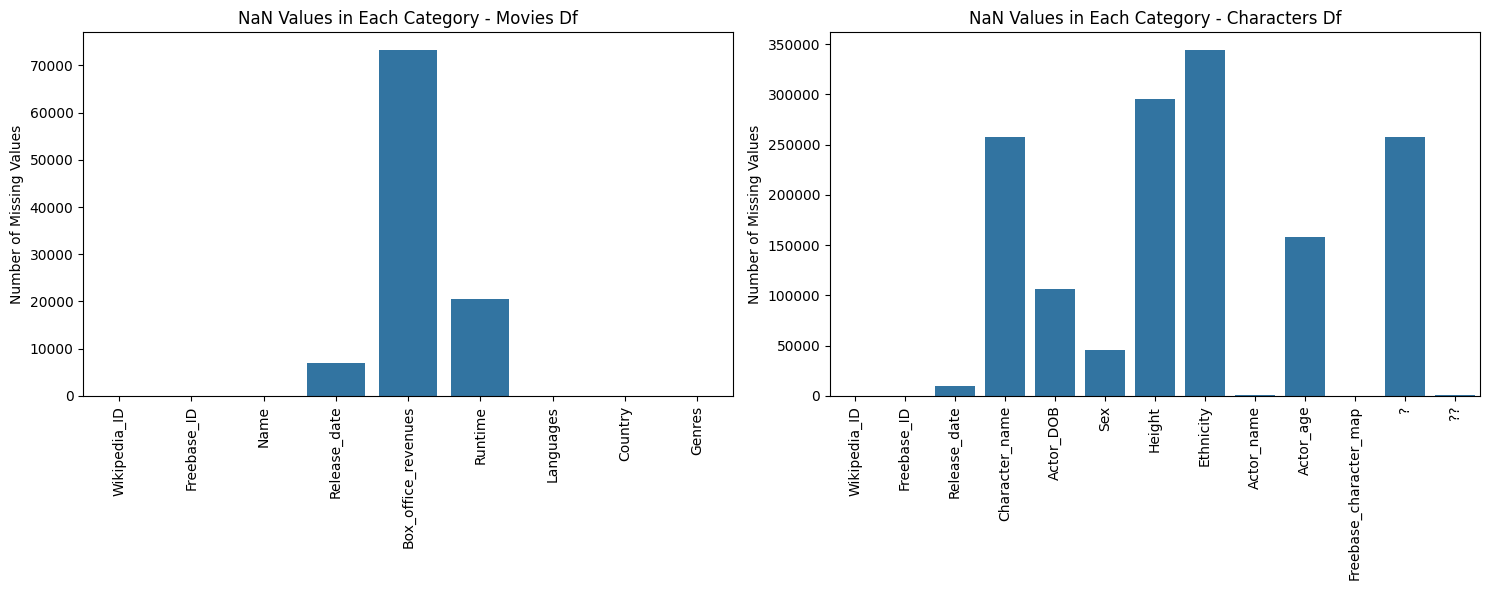

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

missing_values_movies = movies_df.isnull().sum()
missing_values_character = character_df.isnull().sum()

sns.barplot(x=missing_values_movies.index, y=missing_values_movies.values, ax=axs[0])
axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Missing Values')
axs[0].set_title('NaN Values in Each Category - Movies Df')

# Second subplot (could be modified if you want to show different data or style)
sns.barplot(x=missing_values_character.index, y=missing_values_character.values, ax=axs[1])
axs[1].set_xticklabels(missing_values_character.index, rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of Missing Values')
axs[1].set_title('NaN Values in Each Category - Characters Df')

plt.tight_layout()
plt.show()

Removing Nan Values from Character's names

In [106]:
def remove_nan_rows(df:pd.DataFrame,column:str)->pd.DataFrame:
    no_nan_df = df.dropna(subset=[column])
    return no_nan_df

character_df = remove_nan_rows(character_df,'Character_name')



## Common names cleaning

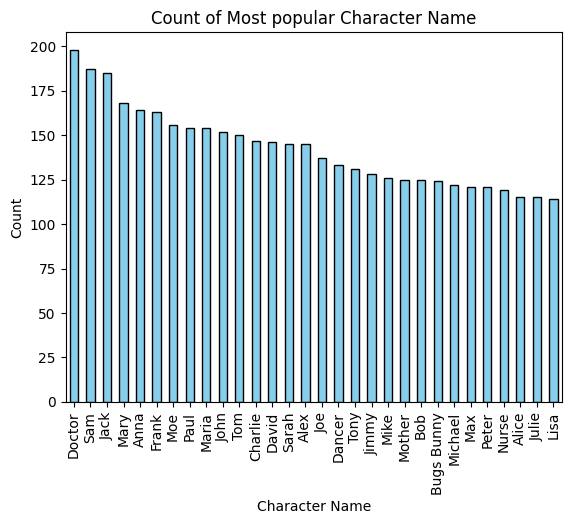

In [107]:
name_counts = character_df['Character_name'].value_counts()

top_names_bar = name_counts.head(30)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

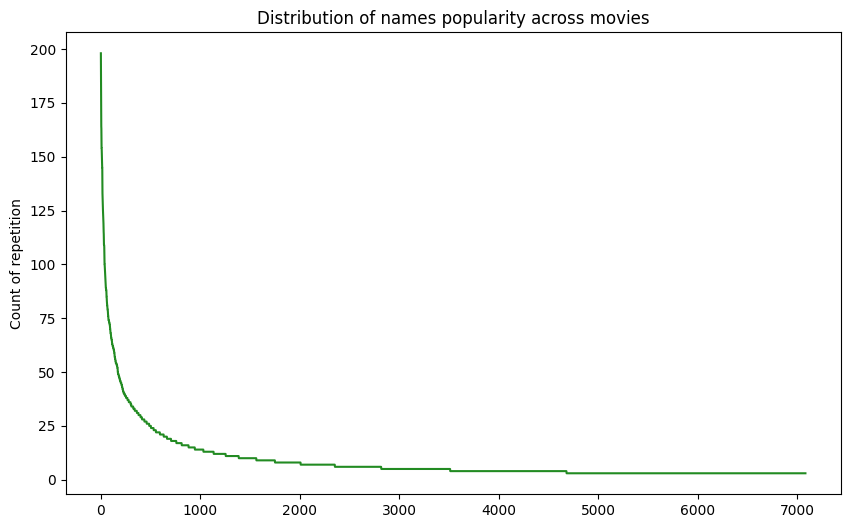

In [108]:
repeated_names = name_counts[name_counts>=3]
plt.figure(figsize=(10, 6))
plt.plot(repeated_names.values, color='forestgreen', linestyle='-', markersize=5)
plt.ylabel("Count of repetition")
plt.title("Distribution of names popularity across movies")
plt.show()

In [109]:
import nltk
nltk.download('words')
from nltk.corpus import words

english_words = set(words.words())                                                        # Liste de 235892 mots anglais   
invalid_chars = ['-', '/', '.', ',',"'", '"', '#',"(",')','0','1','2','3','4','5','6','7','8','9']
def filter_non_english_names(name):
    words_in_name = name.split()                                                             # Sépare le nom en mots individuels
    filtered_words = [word for word in words_in_name if word.lower() not in english_words and all(char not in word for char in invalid_chars)]   # Filtre les mots qui ne sont pas dans la liste des mots anglais et ceux qui contiennent '-' ou '/'
    return ' '.join(filtered_words)    


ModuleNotFoundError: No module named 'nltk'

In [110]:


character_df['Character_name']=character_df['Character_name'].apply(filter_non_english_names)

print(character_df['Character_name'].shape)

(192794,)


In [111]:
# Deleting Empty names

values_filtered = character_df['Character_name'].value_counts()
deleted_names = character_df[character_df['Character_name']==values_filtered.index[0]]
values_filtered.head()

Character_name
          52867
John        520
Tom         304
George      278
Paul        269
Name: count, dtype: int64

In [112]:
kept_names = character_df[character_df['Character_name']!=values_filtered.index[0]]
kept_names.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [113]:
def keep_first_name(name:str)->str:
    return name.split()[0] if name else ""

kept_names['Character_name'] = character_df['Character_name'].apply(keep_first_name)
kept_names.head()

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_32855/3669916037.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


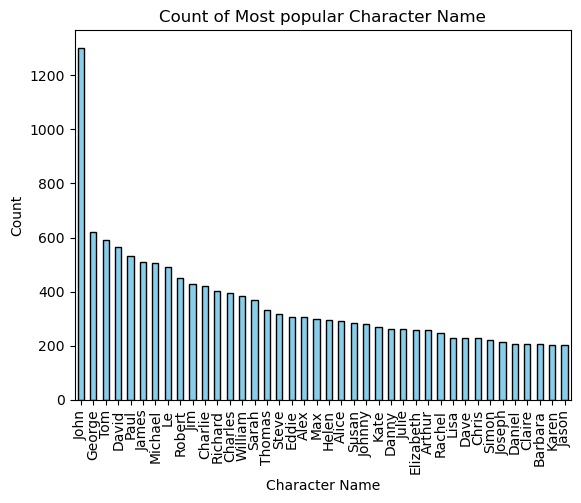

In [114]:
name_counts = kept_names['Character_name'].value_counts()

top_names_bar = name_counts.head(40)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

## Merging With movie dataset

In [115]:
# Merging the 2 datasets and keeping only interesting features

phonetic_df = pd.merge(movies_df,kept_names, on="Wikipedia_ID",how="inner")[['Wikipedia_ID','Name','Languages','Country','Genres','Character_name']]

phonetic_df = remove_nan_rows(phonetic_df,'Character_name')

## First specific plots

In [116]:
male_count = kept_names[kept_names['Sex'] == 'M'].shape[0]
female_count = kept_names[kept_names['Sex'] == 'F'].shape[0]

print(f"Number of male names: {male_count}")
print(f"Number of female names: {female_count}")

Number of male names: 85192
Number of female names: 49895


In [68]:
vowels = set('aeiouy')
def count_vowels(name):
    return sum(1 for char in name.lower() if char in vowels)

consonants = set('bcdfghjklmnpqrstvwxz')
def count_consonants(name):
    return sum(1 for char in name.lower() if char not in vowels)

kept_names['vowel_count'] = kept_names['Character_name'].apply(count_vowels)
kept_names['consonant_count'] = kept_names['Character_name'].apply(count_consonants)

print('Mean number of vowels in name by sex:')
kept_names.groupby('Sex')['vowel_count'].agg(['mean', 'std'])

Mean number of vowels in name by sex:


C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\395007281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['vowel_count'] = kept_names['Character_name'].apply(count_vowels)
C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\395007281.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['consonant_count'] = kept_names['Character_name'].apply(count_consonants)


,mean,std
Sex,,
F,2.694058,0.839876
M,2.380259,0.909831


In [72]:
kept_names['name_length'] = kept_names['Character_name'].apply(lambda name: len(name))
kept_names.groupby('Sex')['name_length'].agg(['mean', 'std'])


C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\681927217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['name_length'] = kept_names['Character_name'].apply(lambda name: len(name))


,mean,std
Sex,,
F,6.036737,1.676422
M,6.026552,1.888028


In [73]:
kept_names['vowel_percentage'] = kept_names['vowel_count'] / kept_names['name_length']
kept_names['consonant_percentage'] = kept_names['consonant_count'] / kept_names['name_length']

print('Pourcentage moyen de voyelles dans les noms de personnages par genre:')
kept_names.groupby('Sex')['vowel_percentage'].agg(['mean', 'std'])

Pourcentage moyen de voyelles dans les noms de personnages par genre:


C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\1447421124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['vowel_percentage'] = kept_names['vowel_count'] / kept_names['name_length']
C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\1447421124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['consonant_percentage'] = kept_names['consonant_count'] / kept_names['name_length']


,mean,std
Sex,,
F,0.452937,0.110251
M,0.398792,0.112547


In [81]:
#Regardons pour hommes et femmes séparémeent
kept_names['first_letter'] = kept_names['Character_name'].apply(lambda name: name[0].lower())
first_letter_counts_H = kept_names[kept_names['Sex'] == 'M']['first_letter'].value_counts()
first_letter_counts_F = kept_names[kept_names['Sex'] == 'F']['first_letter'].value_counts()

first_letter_counts_H_percentage = first_letter_counts_H/male_count
first_letter_counts_F_percentage = first_letter_counts_F/female_count

#Let's merge the two series
first_letter_counts = pd.concat([first_letter_counts_H_percentage, first_letter_counts_F_percentage], axis=1)
first_letter_counts = first_letter_counts.head(26)
first_letter_counts.columns = ['first_letter_men', 'first_letter_women']

C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\4238729803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['first_letter'] = kept_names['Character_name'].apply(lambda name: name[0].lower())


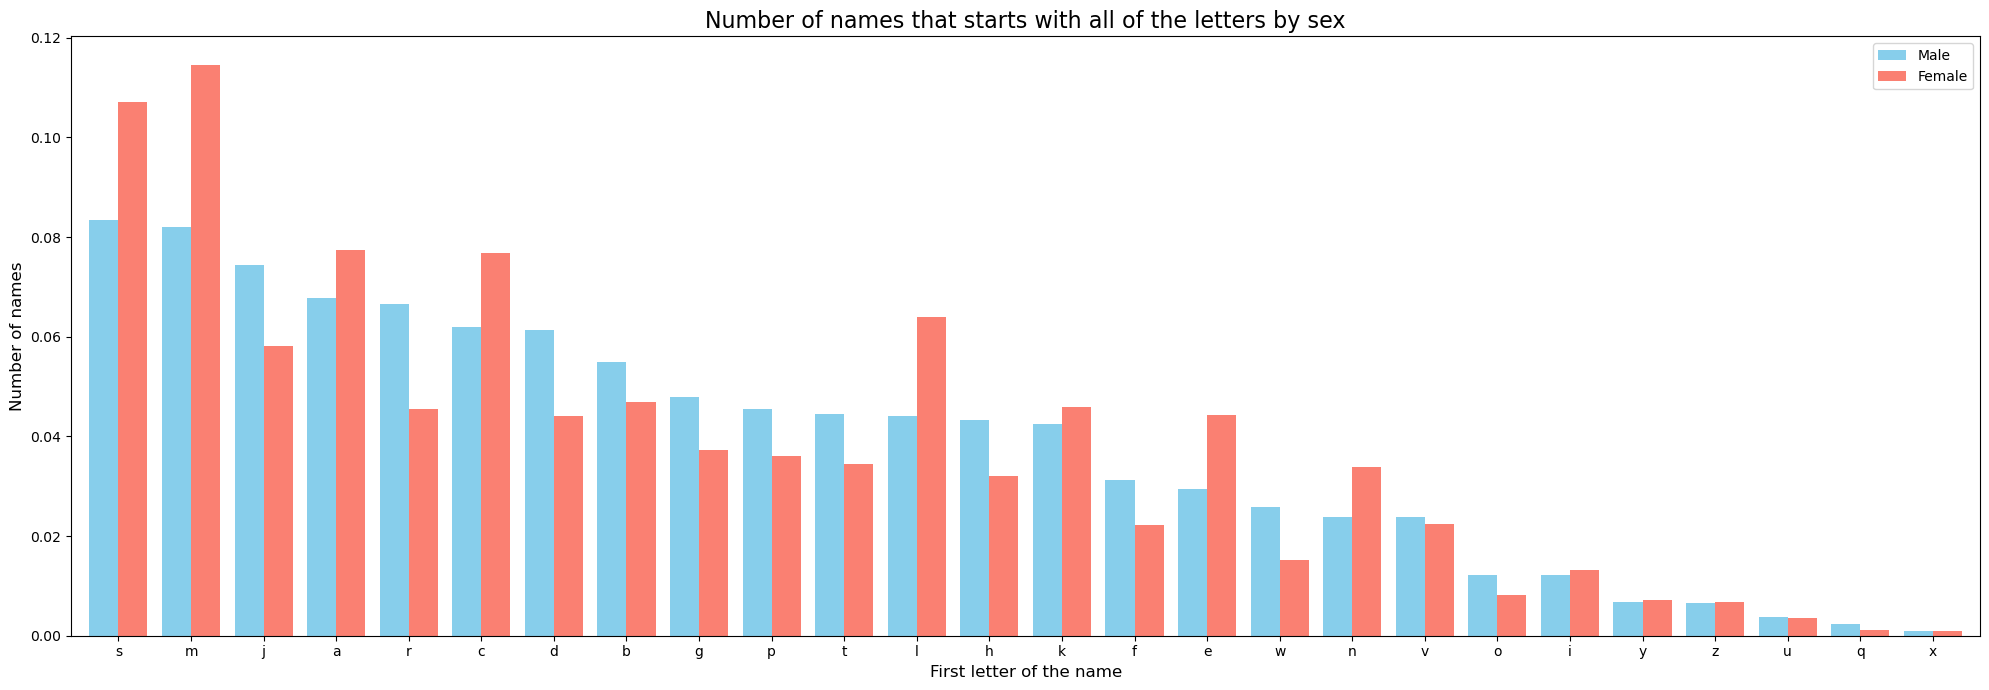

In [ ]:

fig, ax = plt.subplots(figsize=(20, 7))

first_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Percentage of names that starts with all of the letters by sex', fontsize=16)
ax.set_xlabel('First letter of the name', fontsize=12)
ax.set_ylabel('Number of names', fontsize=12)

ax.legend(['Male', 'Female'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [86]:
# Analyze the last letter of each name for men and women separately
kept_names['last_letter'] = kept_names['Character_name'].apply(lambda name: name[-1].lower())
last_letter_counts_H = kept_names[kept_names['Sex'] == 'M']['last_letter'].value_counts()
last_letter_counts_F = kept_names[kept_names['Sex'] == 'F']['last_letter'].value_counts()

last_letter_counts_H_percentage = last_letter_counts_H/male_count
last_letter_counts_F_percentage = last_letter_counts_F/female_count

# Merge the two series
last_letter_counts = pd.concat([last_letter_counts_H_percentage, last_letter_counts_F_percentage], axis=1)
last_letter_counts = last_letter_counts.head(26)
last_letter_counts.columns = ['last_letter_men', 'last_letter_women']

C:\Users\amaur\AppData\Local\Temp\ipykernel_35836\2277614608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_names['last_letter'] = kept_names['Character_name'].apply(lambda name: name[-1].lower())


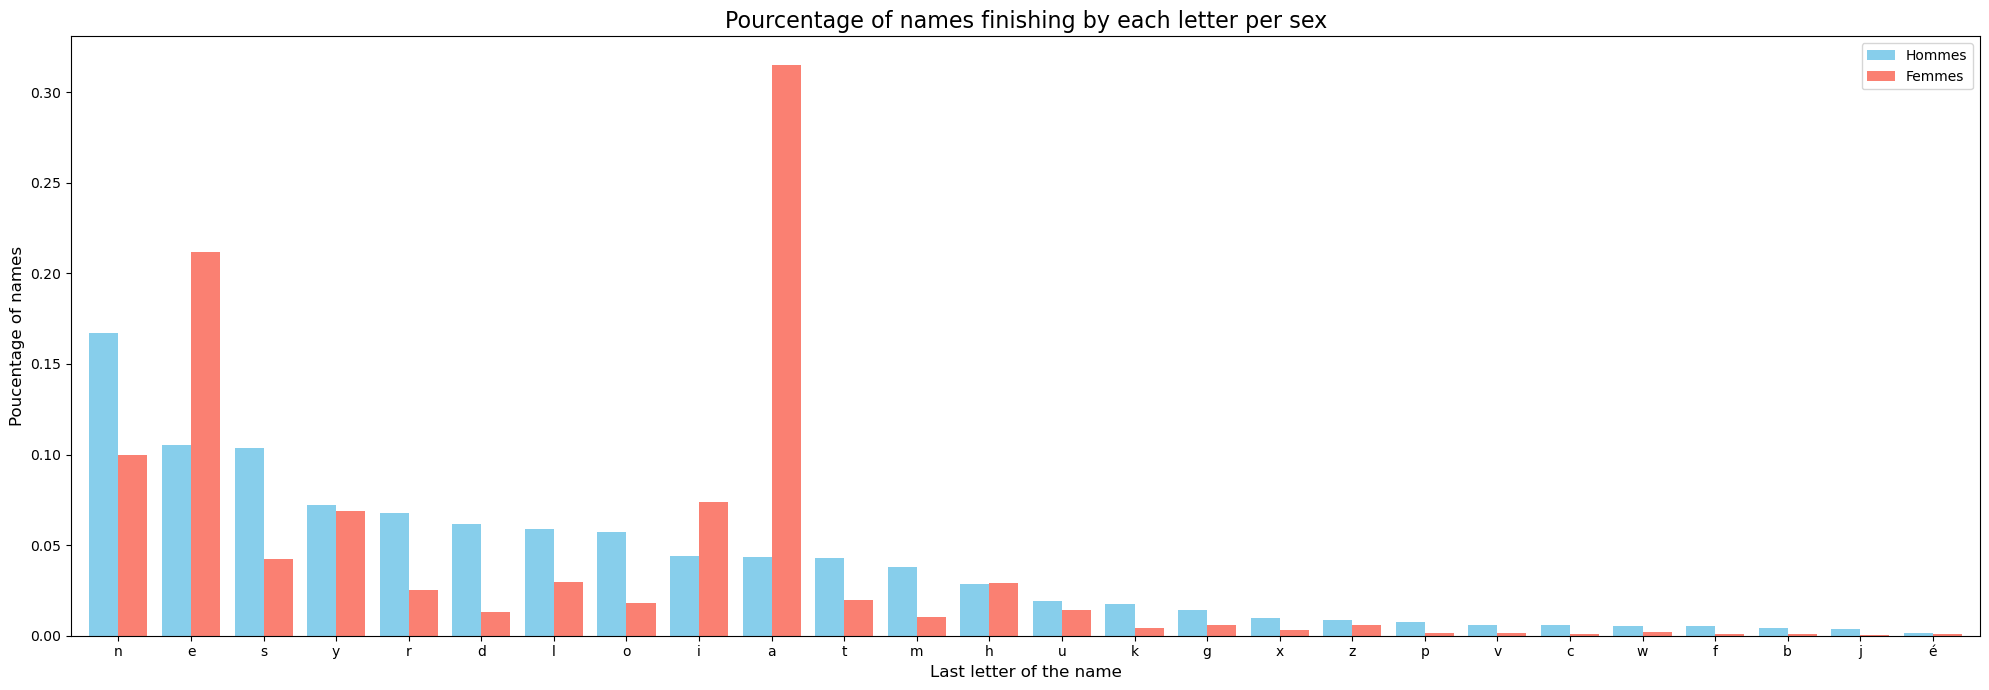

In [88]:
fig, ax = plt.subplots(figsize=(20, 7))

# Tracer les barres pour les hommes et les femmes
last_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

# Ajouter les titres et labels
ax.set_title('Pourcentage of names finishing by each letter per sex', fontsize=16)
ax.set_xlabel('Last letter of the name', fontsize=12)
ax.set_ylabel('Poucentage of names', fontsize=12)

ax.legend(['Hommes', 'Femmes'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud
from pywaffle import Waffle

df_thriller = phonetic_df[phonetic_df['Genres'].apply(lambda genres: 'Thriller' in genres if isinstance(genres, list) else False)]

count_top_names = df_thriller['Character_name'].value_counts().head(20)
tot_top_names = count_top_names.sum()
print(tot_top_names)
count_names = df_thriller['Character_name'].value_counts().sum()
print(count_names)
number_names = len(df_thriller['Character_name'].unique())
print("tot names:",number_names)
names = count_top_names.index.tolist()
values = count_top_names.values.tolist()



NameError: name 'ipa' is not defined

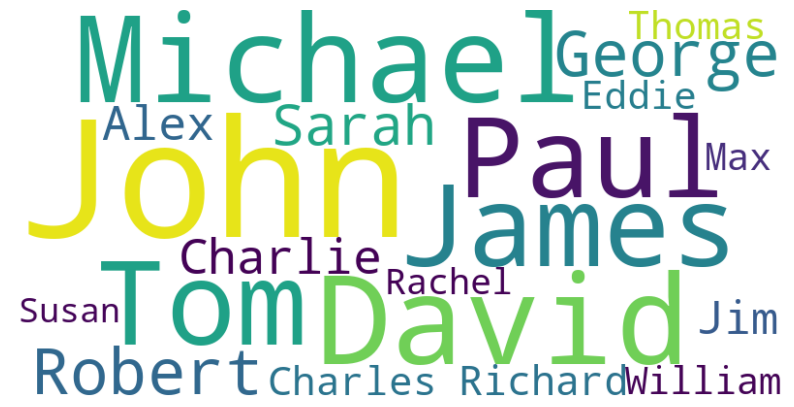

In [117]:
from wordcloud import WordCloud

# Generate a word cloud from the counts
wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1, collocations=False).generate_from_frequencies(count_top_names)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# N-gram Analysis

In [118]:

phonetic_df['Phonetic'] = phonetic_df['Character_name'].apply(lambda x: doublemetaphone(x)[0])
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
char_ngrams = vectorizer.fit_transform(phonetic_df['Character_name'])



In [119]:
# We create a Dataframe with the n-gram features
ngram_df = pd.DataFrame(char_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
ngram_df = ngram_df.astype('float32') # converting to float32 to decrease the computing time

ngram_df.shape # We see that the dimentionality of ngram is very high, potentially increasing exponentially the processing time, we will deal with that later

(139927, 10394)

In [120]:
#le = LabelEncoder()
#phonetic_df['origin_encoded'] = le.fit_transform(phonetic_df['Country'].str[0])
#print(phonetic_df.shape)


In [121]:
# We use minibatch kmeans clustering becease is more efficient for larger datasets
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=1000, random_state=42) 
phonetic_df['cluster'] = kmeans.fit_predict(ngram_df)


In [122]:
# PREND 5 min A RUN

# To reduce n-gram dimentionality we use PCA
ipca = IncrementalPCA(n_components=3, batch_size=500)
pca_result = ipca.fit_transform(ngram_df)




## N-gram pour les pays

In [126]:
df_country = phonetic_df.copy()
df_country['pca_one'] = pca_result[:, 0]
df_country['pca_two'] = pca_result[:, 1]
df_country['pca_three'] = pca_result[:, 2]

In [127]:
import pycountry
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        # Get the alpha-2 country code (e.g., 'US' for United States)
        country_code = pycountry.countries.lookup(country_name).alpha_2
        # Convert country code to continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Map continent code to continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (KeyError, AttributeError, LookupError):
        return None  # Return None if the country is not found or conversion fails

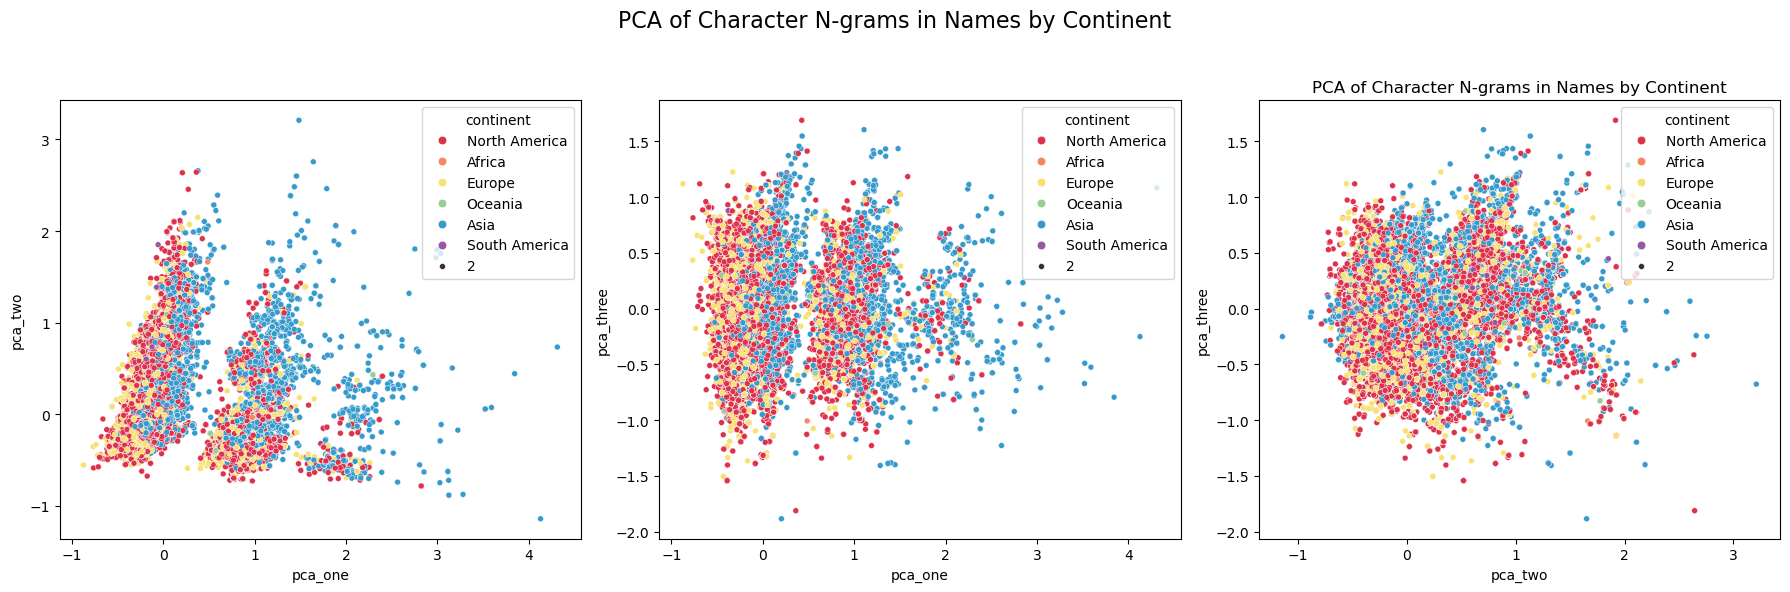

In [129]:
df_country['primary_country'] = df_country['Country'].str[0]
df_country['continent'] = df_country['primary_country'].apply(country_to_continent)


# Visualization
palette = ['#de324c','#f4895f','#f8e16f','#95cf92','#369acc','#9656a2']
fig,axs = plt.subplots(1,3,figsize=(18, 6))
fig.suptitle("PCA of Character N-grams in Names by Continent", fontsize=16)

sns.scatterplot(x="pca_one", y="pca_two", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[0])
sns.scatterplot(x="pca_one", y="pca_three", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[1])
sns.scatterplot(x="pca_two", y="pca_three", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[2])
plt.title("PCA of Character N-grams in Names by Continent")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## Ngram pour les genres

In [45]:
df_genre = phonetic_df.copy()
df_genre['pca_one'] = pca_result[:, 0]
df_genre['pca_two'] = pca_result[:, 1]

In [53]:
top_genres=df_genre['Genres'].explode().value_counts().head(11)
print(top_genres)

Genres
Drama               79733
Comedy              41292
Romance Film        29959
Thriller            28778
Action              24325
Crime Fiction       19257
World cinema        16592
Adventure           15093
Action/Adventure    13616
Indie               12804
Family Film         11356
Name: count, dtype: int64


In [57]:
def top_genre_search(genres:list[str]):
    for genre in genres:
        if genre in top_genres:
            return genre         
    return 'other'
        
df_genre['top_genre'] = df_genre['Genres'].apply(top_genre_search)


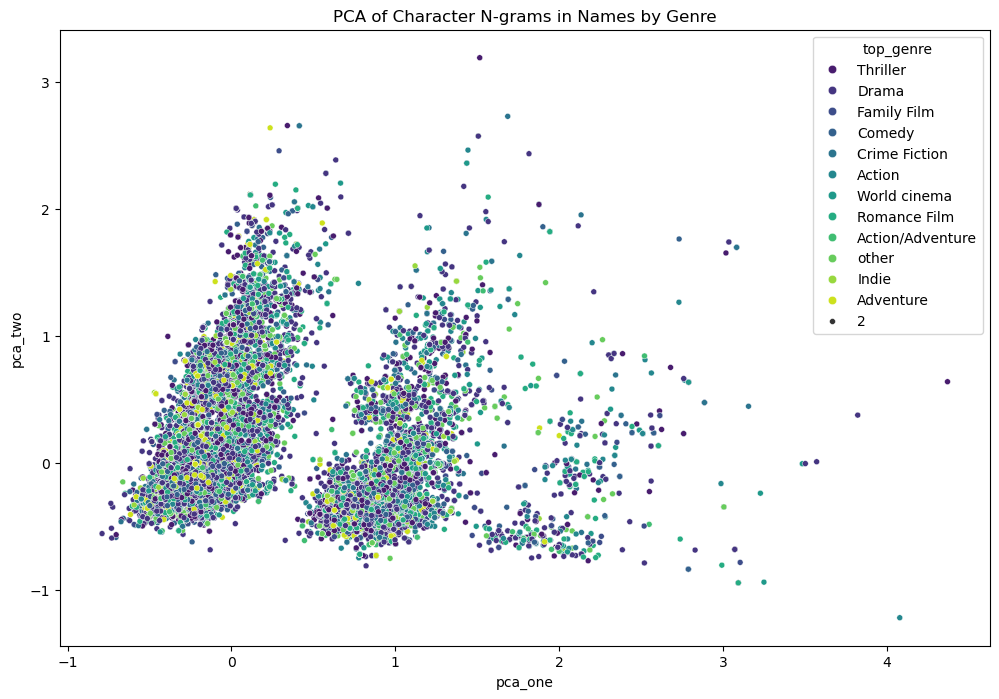

In [58]:

plt.figure(figsize=(12, 8))
sns.scatterplot(x="pca_one", y="pca_two", hue="top_genre", data=df_genre, palette="viridis", size=2,linewidth=0.3)
plt.title("PCA of Character N-grams in Names by Genre")
plt.show()